# Clustering by Sentiment Analysis
- CS데이터를 Clustering하는 내용입니다.
- 감정을 기준으로 분류하였으며, 부정적/긍정적 두 분류로 Classify했습니다.

In [1]:
import pandas as pd
import nltk

# Sentiment analyzing module for sentence
from nltk.sentiment.vader import SentimentIntensityAnalyzer    # Need to Install twython to avoid warning
from tqdm import tqdm_notebook
from datetime import datetime
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Dataset
- Dataset 설명
    - tweet_id: 고유의 익명화 된 Tweet ID. response_tweet_id와 in_response_to_tweet_id에서 참조중.
    - author_id: 고유의 익명화 된 유저 ID. 데이터셋 내의 @부분은 연관된 익명의 user ID로 대체.
    - inbound: 고객에 회사에 Customer Support를 트윗하는 "인바운드"인지. Training 대화 모델을 재정렬할때 유용.
    - created_at: 트윗이 보내진 날짜와 시간.
    - text: 트윗 내용. 전화번호와 이메일 주소와 같은 민감한 정보는 \_\_email\_\_와 같은 마스크 값으로 대체.
    - response_tweet_id: 이 트윗에 응답한 트윗들의 ID. (콤마(,)로 분리)
    - in_response_to_tweet_id: 이 트윗이 응답하고자 하는 트윗의 ID. (존재한다면)
    
감정 분석을 위해 데이터를 정리합니다.

In [2]:
# Load data
tweets = pd.read_csv('Dataset/twcs.csv')

# Get customer requests and company responses 
# Filtering first inbounds
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

# Enable progress reporting on `df.apply` calls
tqdm_notebook().pandas()

A Jupyter Widget

Text의 Sentiment Analysis를 위해 함수를 만들어 줍니다.

In [3]:
# Instantiate sentiment analyzer from NLTK, make helper function
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_for(text: str) -> float:    # Input type is string, and output type is float
    return sentiment_analyzer.polarity_scores(text)['compound']

# Function test
print(sentiment_for('I love it!'))
print(sentiment_for('I would do better than that.'))

0.6696
0.4404


'inbound_sentiment'항목을 만들어 Sentiment Analysis의 점수를 저장합니다.

In [4]:
# Analyze sentiment of inbound customer support requests
inbounds_and_outbounds['inbound_sentiment'] = \
    inbounds_and_outbounds.text_x.progress_apply(sentiment_for)

A Jupyter Widget

### inbounds_and_outbounds 상세내역

In [5]:
inbounds_and_outbounds.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,inbound_sentiment
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0,-0.6249
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0,-0.6249
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0,-0.6249
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0,-0.3182
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0,0.2144


### inbounds_and_outbounds의 각 Feature에 대한 Data Type

In [6]:
print("Dimensions of dataset: inbounds_and_outbounds.shape")
inbounds_and_outbounds.dtypes

Dimensions of dataset: inbounds_and_outbounds.shape


tweet_id_x                    object
author_id_x                   object
inbound_x                       bool
created_at_x                  object
text_x                        object
response_tweet_id_x           object
in_response_to_tweet_id_x    float64
tweet_id_y                    object
author_id_y                   object
inbound_y                       bool
created_at_y                  object
text_y                        object
response_tweet_id_y           object
in_response_to_tweet_id_y    float64
inbound_sentiment            float64
dtype: object

### 값이 있는 항목에 대한 정보

In [7]:
inbounds_and_outbounds.describe()

,in_response_to_tweet_id_x,in_response_to_tweet_id_y,inbound_sentiment
count,0.0,7.942990e+05,794299.000000
mean,NaN,1.557991e+06,0.004726
std,NaN,8.506672e+05,0.448123
min,NaN,8.000000e+00,-0.996900
25%,NaN,8.282100e+05,-0.340000
50%,NaN,1.602066e+06,0.000000
75%,NaN,2.284050e+06,0.361200
max,NaN,2.987950e+06,0.999000


In [8]:
author_grouped = inbounds_and_outbounds.groupby('author_id_y')

In [9]:
top_support_providers = set(author_grouped.agg('count')
                                .sort_values(['tweet_id_x'], ascending=[0])
                                .index[:20]
                                .values)

In [10]:
satisfied_lower = inbounds_and_outbounds['inbound_sentiment'] > 0
satisfied = inbounds_and_outbounds[satisfied_lower]
dissatisfied_upper = inbounds_and_outbounds['inbound_sentiment'] <= 0
dissatisfied = inbounds_and_outbounds[dissatisfied_upper]

### 회사별 트윗 수

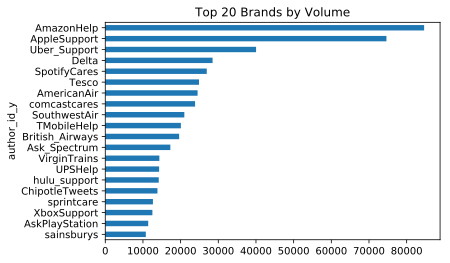

In [11]:
inbounds_and_outbounds \
    .loc[inbounds_and_outbounds.author_id_y.isin(top_support_providers)] \
    .groupby('author_id_y') \
    .tweet_id_x.count() \
    .sort_values() \
    .plot('barh', title='Top 20 Brands by Volume')

### 회사별 고객의 평균(Average) 감정 점수

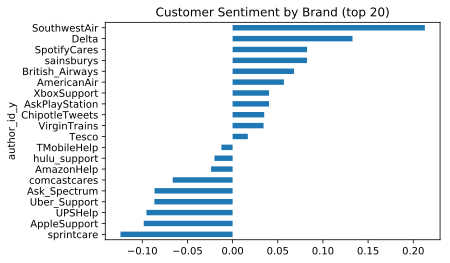

In [12]:
inbounds_and_outbounds \
    .loc[inbounds_and_outbounds.author_id_y.isin(top_support_providers)] \
    .groupby('author_id_y') \
    .inbound_sentiment.mean() \
    .sort_values() \
    .plot('barh', title='Customer Sentiment by Brand (top 20)')

### 회사별 긍정적인 고객의 평균 감정 점수
감정 점수가 0보다 클 경우, 고객이 긍정적인 반응이라고 정의

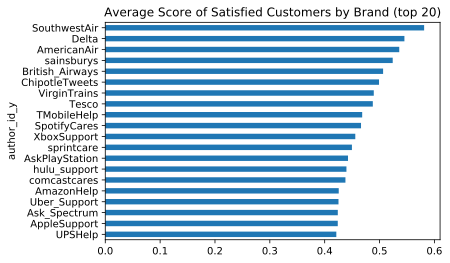

In [13]:
satisfied \
    .loc[inbounds_and_outbounds.author_id_y.isin(top_support_providers)] \
    .groupby('author_id_y') \
    .inbound_sentiment.mean() \
    .sort_values() \
    .plot('barh', title='Average Score of Satisfied Customers by Brand (top 20)')

- SpotifyCares를 제외한 나머지 상위 항목들은 감정의 평균 점수 순위를 따라가는 경향을 보임

### 회사별 부정적인 고객의 평균 감정 점수
감정 점수가 0 이하일 경우, 고객이 부정적인 반응이라고 정의

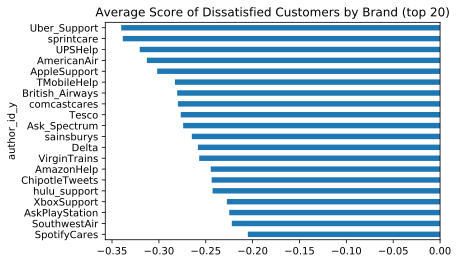

In [14]:
dissatisfied \
    .loc[inbounds_and_outbounds.author_id_y.isin(top_support_providers)] \
    .groupby('author_id_y') \
    .inbound_sentiment.mean() \
    .sort_values(ascending=False) \
    .plot('barh', title='Average Score of Dissatisfied Customers by Brand (top 20)')

- AmericanAir를 제외한 나머지 항목들은 감정의 평균 점수 순위를 역순으로 경향을 보임

긍정적/부정적인 고객의 경향을 따라가지 않는 일부 고객의 경우는 다음과 같이 예상
- 고객의 수가 비슷할 경우, 평균 점수의 절대값이 더 높은 쪽으로 점수의 경향이 
- 각 고객의 평균 점수의 절대값이 비슷할 경우, 고객의 수가 많은쪽으로 점수의 경향이 결정됨
    - 이 경우에 해당이 되는 것으로 예상